In [206]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Load data

In [ ]:
!mkdir data
!curl https://zenodo.org/record/3701939/files/BEELINE-data.zip?download=1 -o data/BEELINE-data.zip
!unzip -d data/ data/BEELINE-data.zip

In [208]:
expression_file= './data/BEELINE-data/inputs/scRNA-Seq/mESC/ExpressionData.csv'
data = pd.read_csv(expression_file, header=0, index_col=0)
print(np.shape(data))
data.head()

(18385, 421)


,RamDA_mESC_00h_A04,RamDA_mESC_00h_A05,RamDA_mESC_00h_A06,RamDA_mESC_00h_A07,RamDA_mESC_00h_A08,RamDA_mESC_00h_A09,RamDA_mESC_00h_A12,RamDA_mESC_00h_B01,RamDA_mESC_00h_B02,RamDA_mESC_00h_B03,...,RamDA_mESC_72h_H03,RamDA_mESC_72h_H04,RamDA_mESC_72h_H05,RamDA_mESC_72h_H06,RamDA_mESC_72h_H07,RamDA_mESC_72h_H08,RamDA_mESC_72h_H09,RamDA_mESC_72h_H10,RamDA_mESC_72h_H11,RamDA_mESC_72h_H12
0610009B22Rik,0.719390,0.726742,0.750426,0.731080,1.010086,0.444663,0.335425,0.728633,0.633124,1.021974,...,0.068023,1.052183,0.000000,0.872356,0.753568,0.427959,0.982851,0.498770,0.446937,0.389969
0610009E02Rik,0.000000,0.000000,0.078196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000074,...,0.352013,0.000000,0.139382,0.000000,0.000000,0.148759,0.000000,0.103263,0.000000,0.115930
0610009L18Rik,0.000000,0.110853,0.000000,0.000000,0.000000,0.202815,0.000000,0.168117,0.000000,0.425255,...,0.000000,0.000000,0.000000,0.000000,0.281088,0.000000,0.000000,0.000000,0.000000,0.000000
0610010F05Rik,0.781882,0.274776,0.340260,0.656344,0.376044,0.393048,0.411821,0.193958,0.249195,0.477298,...,0.354434,0.000000,0.404818,0.000000,0.248052,0.431131,0.140880,0.000000,0.487615,0.068094
0610010K14Rik,1.252929,1.177042,1.421597,1.232133,1.208000,1.004594,1.443681,1.677951,1.348406,2.032282,...,0.315996,0.957456,1.476827,1.349023,1.038066,0.619080,1.540838,1.377568,1.733855,0.896897


In [209]:
time_file= './data/BEELINE-data/inputs/scRNA-Seq/mESC/PseudoTime.csv'
pseudotime = pd.read_csv(time_file, header=0, index_col=0)
pseudotime.head()

,PseudoTime
RamDA_mESC_00h_A04,37.428147
RamDA_mESC_00h_A05,36.715898
RamDA_mESC_00h_A06,40.149337
RamDA_mESC_00h_A07,33.726961
RamDA_mESC_00h_A08,35.075278


In [210]:
labels=pseudotime.index
pseudotime["time_points"]=[int(i.split('_')[2][:-1]) for i in labels]
time=pseudotime.values

In [211]:
counts=np.transpose(data.values)
X_train, X_temp, y_train, y_temp = train_test_split(counts, time, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5)

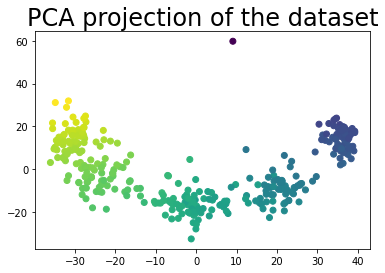

In [212]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_train)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train[:,0])
plt.title('PCA projection of the dataset', fontsize=24)
plt.show()

# Autoencoder

In [391]:
class Autoencoder(Model):
  def __init__(self, latent_dim, dim_x):
    super(Autoencoder, self).__init__()
    self.dim_x = dim_x
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform'),
      layers.BatchNormalization(axis=1),
      #layers.Dense(8, activation="relu"),
      #layers.BatchNormalization(axis=1),
      layers.Dense(latent_dim, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=(latent_dim,)),
      layers.Dense(128, activation="relu"),
      layers.BatchNormalization(axis=1),
      #layers.Dense(512, activation="relu"),
      layers.Dense(self.dim_x, activation="relu")])


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [392]:
latent_dim = 1
input_shape = np.shape(X_train)[1]
autoencoder = Autoencoder(latent_dim, input_shape)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(1e-3)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError()) #'mae')

In [396]:
history = autoencoder.fit(X_train, X_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_val, X_val),
          shuffle=True)

Epoch 1/100
11/11 [==============================] - 0s 25ms/step - loss: 0.1221 - val_loss: 0.1220
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 0.1220 - val_loss: 0.1219
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1222 - val_loss: 0.1220
Epoch 4/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1211 - val_loss: 0.1230
Epoch 5/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1232 - val_loss: 0.1241
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1210 - val_loss: 0.1254
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1205 - val_loss: 0.1274
Epoch 8/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1209 - val_loss: 0.1246
Epoch 9/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1209 - val_loss: 0.1220
Epoch 10/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1216 - val_loss: 0.1217

11/11 [==============================] - 0s 21ms/step - loss: 0.1187 - val_loss: 0.1211
Epoch 83/100
11/11 [==============================] - 0s 17ms/step - loss: 0.1201 - val_loss: 0.1195
Epoch 84/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1191 - val_loss: 0.1188
Epoch 85/100
11/11 [==============================] - 0s 19ms/step - loss: 0.1200 - val_loss: 0.1191
Epoch 86/100
11/11 [==============================] - 0s 20ms/step - loss: 0.1196 - val_loss: 0.1188
Epoch 87/100
11/11 [==============================] - 0s 19ms/step - loss: 0.1193 - val_loss: 0.1192
Epoch 88/100
11/11 [==============================] - 0s 19ms/step - loss: 0.1186 - val_loss: 0.1200
Epoch 89/100
11/11 [==============================] - 0s 18ms/step - loss: 0.1212 - val_loss: 0.1187
Epoch 90/100
11/11 [==============================] - 0s 19ms/step - loss: 0.1175 - val_loss: 0.1196
Epoch 91/100
11/11 [==============================] - 0s 19ms/step - loss: 0.1183 - val_loss: 0.1191
Epo

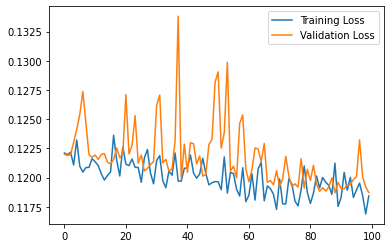

In [397]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

0.2231778327048951


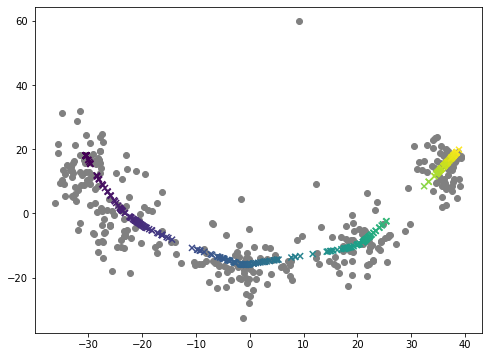

In [398]:
pseudocells = autoencoder.decoder(autoencoder.encoder(X_train)).numpy()
print(mean_absolute_error(X_train,pseudocells))
new_embedding = pca.transform(pseudocells)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(x_pca[:, 0], x_pca[:, 1], c='grey')
ax.scatter(new_embedding[:, 0], new_embedding[:, 1], marker='x', c=autoencoder.encoder(X_train))
plt.show()

# VAE

In [342]:
class VAE(Model):
    def __init__(self, latent_dim, dim_x, kl_weight, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.dim_x = dim_x
        self.latent_dim = latent_dim   
        self.kl_weight = kl_weight
      
        self.encoder = tf.keras.Sequential([
          layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform'),
          layers.BatchNormalization(axis=1),
          layers.Dense(2*self.latent_dim, activation=None)])

        self.decoder = tf.keras.Sequential([
          layers.InputLayer(input_shape=(self.latent_dim,)),
          layers.Dense(128, activation="relu"),
          layers.BatchNormalization(axis=1),
          #layers.Dense(512, activation="relu"),
          layers.Dense(self.dim_x, activation="relu")])
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
        
    def _z(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        eps = K.random_normal(shape=(batch, dim))
        return eps * tf.exp(log_var * .5) + mean

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var = tf.split(self.encoder(data), num_or_size_splits=2, axis=1)
            z = self._z(mean, log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(losses.MSE(data, reconstruction))
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.kl_weight*kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [382]:
epochs = 20
batch_size = 4
lr = 0.01
latent_dim=1
kl_w=0.0001


vae = VAE(latent_dim=latent_dim, dim_x=input_shape, kl_weight=kl_w)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
train_history = vae.fit(X_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/20
84/84 [==============================] - 1s 9ms/step - loss: 16233552.4058 - reconstruction_loss: 8457914.0000 - kl_loss: 4419081728.0000
Epoch 2/20
84/84 [==============================] - 1s 9ms/step - loss: 1.4345 - reconstruction_loss: 1.3488 - kl_loss: 729.9587
Epoch 3/20
84/84 [==============================] - 1s 9ms/step - loss: 1.3845 - reconstruction_loss: 1.3219 - kl_loss: 622.4727
Epoch 4/20
84/84 [==============================] - 1s 9ms/step - loss: 1.3835 - reconstruction_loss: 1.3094 - kl_loss: 572.4409
Epoch 5/20
84/84 [==============================] - 1s 9ms/step - loss: 1.3603 - reconstruction_loss: 1.3069 - kl_loss: 515.3697
Epoch 6/20
84/84 [==============================] - 1s 10ms/step - loss: 1.3544 - reconstruction_loss: 1.2998 - kl_loss: 500.8108
Epoch 7/20
84/84 [==============================] - 1s 9ms/step - loss: 1.3400 - reconstruction_loss: 1.2922 - kl_loss: 462.7593
Epoch 8/20
84/84 [==============================] - 1s 10ms/step - loss: 1.3

In [403]:
train_history = vae.fit(X_train, batch_size=64, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
6/6 [==============================] - 0s 29ms/step - loss: 0.1649 - reconstruction_loss: 0.1315 - kl_loss: 335.9472
Epoch 2/20
6/6 [==============================] - 0s 22ms/step - loss: 0.1649 - reconstruction_loss: 0.1297 - kl_loss: 340.3202
Epoch 3/20
6/6 [==============================] - 0s 21ms/step - loss: 0.1619 - reconstruction_loss: 0.1284 - kl_loss: 339.4191
Epoch 4/20
6/6 [==============================] - 0s 22ms/step - loss: 0.1641 - reconstruction_loss: 0.1280 - kl_loss: 336.3463
Epoch 5/20
6/6 [==============================] - 0s 22ms/step - loss: 0.1637 - reconstruction_loss: 0.1309 - kl_loss: 333.6982
Epoch 6/20
6/6 [==============================] - 0s 23ms/step - loss: 0.1656 - reconstruction_loss: 0.1334 - kl_loss: 336.3283
Epoch 7/20
6/6 [==============================] - 0s 22ms/step - loss: 0.1655 - reconstruction_loss: 0.1320 - kl_loss: 335.8011
Epoch 8/20
6/6 [==============================] - 0s 22ms/step - loss: 0.1634 - reconstruction_loss: 0.1

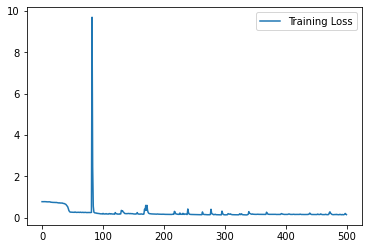

In [399]:
plt.plot(train_history.history["loss"], label="Training Loss")
plt.legend()

0.12775949975097953


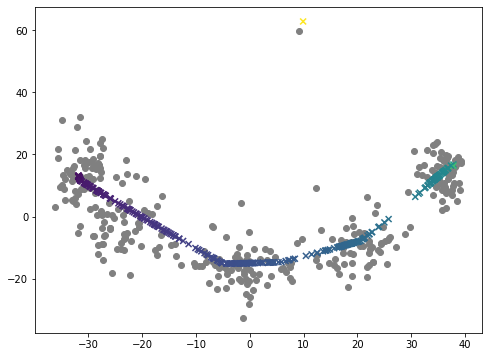

In [404]:
mean, log_var = tf.split(vae.encoder(X_train), num_or_size_splits=2, axis=1)
pseudocells = vae.decoder(mean).numpy()
print(mean_squared_error(X_train,pseudocells))
new_embedding = pca.transform(pseudocells)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(x_pca[:, 0], x_pca[:, 1], c='grey')
ax.scatter(new_embedding[:, 0], new_embedding[:, 1], marker='x', c=mean)
plt.show()

# Add discrete variables

In [515]:
expression_file= './data/BEELINE-data/inputs/Curated/GSD/GSD-2000-10/ExpressionData.csv'
data = pd.read_csv(expression_file, header=0, index_col=0)
print(np.shape(data))
data.head()

(19, 2000)


,E1548_324,E340_673,E1702_686,E1949_156,E1633_634,E128_264,E1186_193,E858_193,E1622_143,E36_116,...,E676_452,E1154_197,E1000_589,E474_600,E1924_555,E504_464,E1529_465,E1729_648,E165_474,E1687_779
AMH,0.002909,0.003040,1.605696,0.018590,0.043192,0.020711,0.249017,0.012109,0.003422,0.016452,...,0.021843,0.010430,0.001598,0.008627,0.001814,0.011646,0.008613,0.093081,0.327725,1.217408
CBX2,0.168192,0.004540,0.006325,0.001370,0.003542,0.012531,0.007289,0.564863,1.690360,1.474516,...,0.023850,0.001463,0.007883,0.001089,0.020784,0.012650,0.000817,0.021929,0.028765,0.001014
CTNNB1,0.368903,1.681789,0.005434,0.492868,1.729966,0.467047,0.014585,0.045424,0.013105,0.002122,...,1.529865,0.998823,1.482901,1.956458,1.706353,1.349308,1.719926,1.706825,0.009385,0.013277
DHH,0.006611,0.134808,1.301742,0.012034,0.136107,0.056355,0.027885,0.016068,0.002859,0.010045,...,0.026786,0.043234,0.039034,0.000779,0.012669,0.004988,0.007643,0.005150,0.743685,1.334302
DKK1,1.142703,0.004768,1.160747,0.009268,0.014420,1.314525,0.024223,0.897867,0.017241,0.048969,...,0.001767,0.010197,0.036171,0.009440,0.030357,0.014191,0.028392,0.006316,2.274837,1.145034


In [516]:
BF_counts=np.transpose(data.values)
BF_X_train, BF_X_temp, BF_y_train, BF_y_temp = train_test_split(BF_counts, BF_counts, train_size=0.8)
BF_X_val, BF_X_test, BF_y_val, BF_y_test = train_test_split(BF_X_temp, BF_y_temp, train_size=0.5)

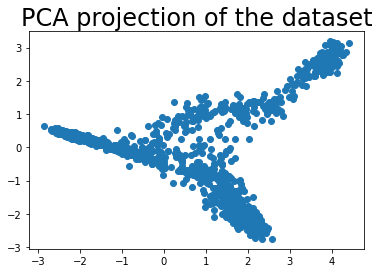

In [517]:
BF_pca = PCA(n_components=2)
BF_x_pca = BF_pca.fit_transform(BF_X_train)
plt.scatter(BF_x_pca[:, 0], BF_x_pca[:, 1])
plt.title('PCA projection of the dataset', fontsize=24)
plt.show()

In [580]:
class DVAE(Model):
    def __init__(self, latent_dim, dim_x, dim_k, kl_weight, c_w, temperature, **kwargs):
        super(DVAE, self).__init__(**kwargs)
        self.dim_x = dim_x
        self.dim_k = dim_k
        self.temperature = temperature
        self.latent_dim = latent_dim   
        self.kl_weight = kl_weight
        self.c_w = c_w
        self.encoder = tf.keras.Sequential([
          layers.Dense(4, activation="relu", kernel_initializer='glorot_uniform'),
          layers.BatchNormalization(axis=1),
          layers.Dense(2*self.latent_dim+self.dim_k, activation=None)])

        self.decoder = tf.keras.Sequential([
          layers.InputLayer(input_shape=(self.latent_dim+self.dim_k,)),
          layers.Dense(4, activation=None),
          layers.BatchNormalization(axis=1),
          #layers.Dense(512, activation="relu"),
          layers.Dense(self.dim_x, activation="relu")])

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def _z(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        eps = K.random_normal(shape=(batch, dim))
        return eps * tf.exp(log_var * .5) + mean

    def _gumbel_softmax_sample(self, logits, temperature, epsi=2e-20): 
        U = tf.random.uniform(tf.shape(logits),minval=0,maxval=1)
        y = logits - tf.math.log(-tf.math.log(U + epsi) + epsi)
        return tf.nn.softmax( y / temperature)

    def _gumbel_softmax(self, logits, temperature, hard=False):
        y = self._gumbel_softmax_sample(logits, temperature)
        if hard:
            k = tf.shape(logits)[-1]
            #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
            y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        return y
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, pi = tf.split(self.encoder(data), num_or_size_splits=[self.latent_dim,self.latent_dim,self.dim_k], axis=1)
            z = self._z(mean, log_var)
            k = self._gumbel_softmax(pi, self.temperature)
            reconstruction = self.decoder(tf.concat([z, k], 1))
            reconstruction_loss = tf.reduce_mean(losses.MSE(data, reconstruction))
            kl_loss = -0.5 * (1 + log_var + - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            p=tf.exp(pi)/tf.reshape(tf.reduce_sum(tf.exp(pi),axis=1), (-1, 1))
            categorial_loss = tf.math.reduce_sum(p*tf.math.log(p))
            total_loss = reconstruction_loss + self.kl_weight*kl_loss + self.c_w* categorial_loss 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [581]:
epochs = 100
batch_size = 16
lr = 0.001
latent_dim=1
kl_w=0.001
c_w=0.001
dim_k = 2
dim_x = 19
temperature = 0.1

dvae = DVAE(latent_dim, dim_x, dim_k, kl_w, c_w, temperature)
dvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
train_history = dvae.fit(BF_X_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/100
100/100 [==============================] - 1s 794us/step - loss: 0.8875 - reconstruction_loss: 0.7989 - kl_loss: 1.0301
Epoch 2/100
100/100 [==============================] - 0s 761us/step - loss: 0.5191 - reconstruction_loss: 0.4560 - kl_loss: 1.7696
Epoch 3/100
100/100 [==============================] - 0s 739us/step - loss: 0.3035 - reconstruction_loss: 0.2800 - kl_loss: 2.5840
Epoch 4/100
100/100 [==============================] - 0s 736us/step - loss: 0.2428 - reconstruction_loss: 0.2299 - kl_loss: 3.1301
Epoch 5/100
100/100 [==============================] - 0s 746us/step - loss: 0.2091 - reconstruction_loss: 0.2048 - kl_loss: 3.4458
Epoch 6/100
100/100 [==============================] - 0s 744us/step - loss: 0.1994 - reconstruction_loss: 0.1940 - kl_loss: 3.7288
Epoch 7/100
100/100 [==============================] - 0s 760us/step - loss: 0.1977 - reconstruction_loss: 0.1901 - kl_loss: 3.9223
Epoch 8/100
100/100 [==============================] - 0s 750us/step - loss:

100/100 [==============================] - 0s 747us/step - loss: 0.1581 - reconstruction_loss: 0.1547 - kl_loss: 4.0364
Epoch 63/100
100/100 [==============================] - 0s 756us/step - loss: 0.1622 - reconstruction_loss: 0.1549 - kl_loss: 4.0248
Epoch 64/100
100/100 [==============================] - 0s 740us/step - loss: 0.1561 - reconstruction_loss: 0.1545 - kl_loss: 3.9769
Epoch 65/100
100/100 [==============================] - 0s 742us/step - loss: 0.1591 - reconstruction_loss: 0.1549 - kl_loss: 4.0234
Epoch 66/100
100/100 [==============================] - 0s 753us/step - loss: 0.1583 - reconstruction_loss: 0.1543 - kl_loss: 3.9701
Epoch 67/100
100/100 [==============================] - 0s 732us/step - loss: 0.1550 - reconstruction_loss: 0.1534 - kl_loss: 4.0497
Epoch 68/100
100/100 [==============================] - 0s 726us/step - loss: 0.1545 - reconstruction_loss: 0.1531 - kl_loss: 4.0228
Epoch 69/100
100/100 [==============================] - 0s 740us/step - loss: 0.15

In [594]:
train_history = dvae.fit(BF_X_train, batch_size=32, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1147 - reconstruction_loss: 0.1206 - kl_loss: 3.5217
Epoch 2/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1085 - reconstruction_loss: 0.1202 - kl_loss: 3.5171
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1070 - reconstruction_loss: 0.1206 - kl_loss: 3.5082
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1063 - reconstruction_loss: 0.1201 - kl_loss: 3.4967
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1089 - reconstruction_loss: 0.1212 - kl_loss: 3.4960
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1097 - reconstruction_loss: 0.1203 - kl_loss: 3.5272
Epoch 7/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1133 - reconstruction_loss: 0.1206 - kl_loss: 3.5234
Epoch 8/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1117 - reconstruction_loss: 0

50/50 [==============================] - 0s 1ms/step - loss: 0.1115 - reconstruction_loss: 0.1200 - kl_loss: 3.5166
Epoch 65/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1160 - reconstruction_loss: 0.1207 - kl_loss: 3.5361
Epoch 66/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1126 - reconstruction_loss: 0.1206 - kl_loss: 3.5156
Epoch 67/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1111 - reconstruction_loss: 0.1202 - kl_loss: 3.4722
Epoch 68/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1082 - reconstruction_loss: 0.1197 - kl_loss: 3.4964
Epoch 69/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1123 - reconstruction_loss: 0.1211 - kl_loss: 3.5016
Epoch 70/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1111 - reconstruction_loss: 0.1212 - kl_loss: 3.5334
Epoch 71/100
50/50 [==============================] - 0s 1ms/step - loss: 0.1164 - reconstruction_loss: 0.1201

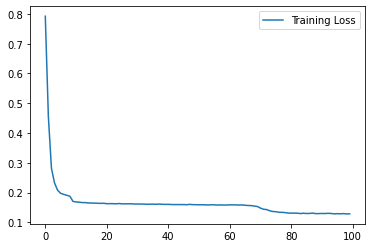

In [582]:
plt.plot(train_history.history["loss"], label="Training Loss")
plt.legend()

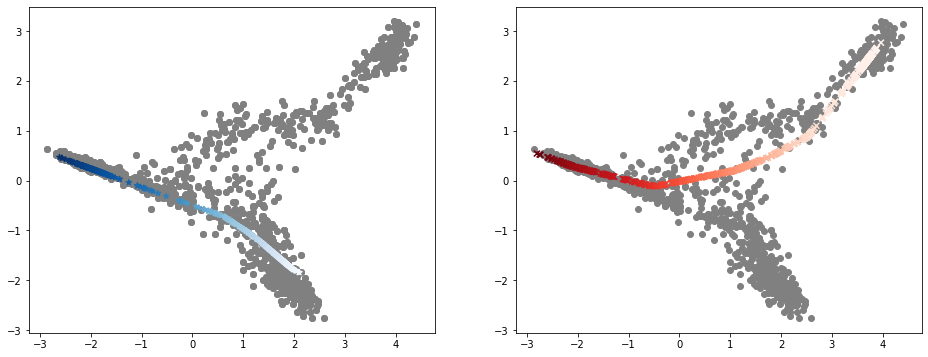

In [596]:
mean, log_var, pi = tf.split(dvae.encoder(BF_X_train), num_or_size_splits=[latent_dim, latent_dim, dim_k], axis=1)
k = dvae._gumbel_softmax(pi, temperature,hard=False)
BF_pseudocells = dvae.decoder(tf.concat([mean, k], 1)).numpy()

BF_new_embedding = BF_pca.transform(BF_pseudocells)

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(BF_x_pca[:, 0], BF_x_pca[:, 1], c='grey')
markers = ['*','x','o']
cmaps = ['Blues', 'Reds', 'Greens']

for i in range(dim_k):
    idx = (k[:,i]==1)
    ax[i].scatter(BF_x_pca[:, 0], BF_x_pca[:, 1], c='grey')
    ax[i].scatter(BF_new_embedding[idx, 0], BF_new_embedding[idx, 1], marker=markers[i], c=mean[idx], cmap=cmaps[i])
    
plt.show()

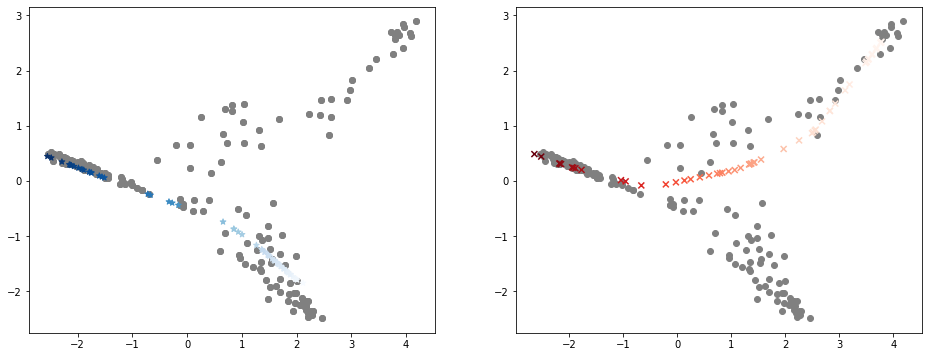

In [598]:
mean, log_var, pi = tf.split(dvae.encoder(BF_X_val), num_or_size_splits=[latent_dim, latent_dim, dim_k], axis=1)
k = dvae._gumbel_softmax(pi, temperature,hard=False)
BF_pseudocells = dvae.decoder(tf.concat([mean, k], 1)).numpy()

BF_x_pca = BF_pca.transform(BF_X_val)
BF_new_embedding = BF_pca.transform(BF_pseudocells)

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(BF_x_pca[:, 0], BF_x_pca[:, 1], c='grey')
markers = ['*','x','o']
cmaps = ['Blues', 'Reds', 'Greens']

for i in range(dim_k):
    idx = (k[:,i]==1)
    ax[i].scatter(BF_x_pca[:, 0], BF_x_pca[:, 1], c='grey')
    ax[i].scatter(BF_new_embedding[idx, 0], BF_new_embedding[idx, 1], marker=markers[i], c=mean[idx], cmap=cmaps[i])
    
plt.show()